# Implementación del Vision Transformer


En este cuaderno, implementaremos el *Vision Transformer* y lo probaremos con el conjunto de datos CIFAR-10. La implementación retoma elementos del cuaderno 2 "GptFromScratch", por lo que es necesario seguirlos en orden.

Nos basamos en el artículo [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929).

Aquí está la figura clave del artículo que implementaremos paso a paso:

![ViT](./images/ViT.png)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Detection automatique du GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"using device: {device}")

using device: cpu


## Reutilización del código anterior


Primero, reutilizaremos el código del [cuaderno 2 de este curso](../07_Transformers/02_GptFromScratch.ipynb) con algunas modificaciones.


### Capa de autoatención


Si lo recuerdan, en el cuaderno 2 implementamos la capa *masked multi-head attention* para entrenar un *transformer* de tipo *decoder*. Para imágenes, queremos un *transformer* de tipo *encoder*, por lo que debemos modificar nuestra implementación.

Es bastante sencillo: teníamos una multiplicación por una matriz triangular inferior para enmascarar el "futuro" en el *decoder*. Pero en el *encoder*, no queremos enmascarar el futuro, por lo que simplemente eliminamos esta multiplicación.

Aquí está el código Python ajustado:


In [2]:
class Head_enc(nn.Module):
    """ Couche de self-attention unique """

    def __init__(self, head_size,n_embd,dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Le * C**-0.5 correspond à la normalisation par la racine de head_size
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # On a supprimer le masquage du futur
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

### Autoatención multi-cabeza


Para tener múltiples *heads*, simplemente reutilizaremos nuestra clase del cuaderno 2, pero usando *Head_enc* en lugar de *Head*:


In [3]:
class MultiHeadAttention(nn.Module):
    """ Plusieurs couches de self attention en parallèle"""

    def __init__(self, num_heads, head_size,n_embd,dropout):
        super().__init__()
        # Création de num_head couches head_enc de taille head_size
        self.heads = nn.ModuleList([Head_enc(head_size,n_embd,dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Capa feed forward


También reutilizamos nuestra implementación de la *feed forward layer*, solo cambiamos la función de activación *ReLU* por *GeLU* como se describe en el artículo:


In [4]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd,dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

### Bloque del codificador Transformer


Finalmente, podemos construir nuestro *bloque* del codificador *transformer* que corresponde al de la figura anterior:


In [5]:
class TransformerBlock(nn.Module):
    """ Block transformer"""

    def __init__(self, n_embd, n_head,dropout=0.):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size,n_embd,dropout)
        self.ffwd = FeedFoward(n_embd,dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Nota**: Aquí he pasado rápidamente por estas capas porque se implementaron en detalle en el cuaderno 2. Les invito a consultarlo en caso de incomprensión.


## Implementación de la red


Ahora implementaremos la red paso a paso.


### División de la imagen en parches


El primer paso descrito en el artículo es dividir la imagen en *parches*:

Cada imagen se divide en $N$ *parches* de tamaño $p \times p$, luego los *parches* se aplanan (*flatten*). Pasamos de una dimensión de la imagen $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ a una secuencia de *parches* $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$.

![parches](./images/patchs.png)


Para lograr esto, recuperaremos una imagen del conjunto de datos CIFAR-10 como ejemplo, lo que nos permitirá visualizar si nuestro código funciona.


In [6]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.CIFAR10(root='./../data', train=True, download=True,transform=transform)

Files already downloaded and verified


Recuperemos una imagen simple de este conjunto de datos para realizar nuestras pruebas:


torch.Size([3, 32, 32])


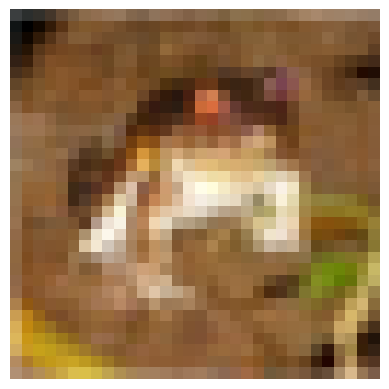

In [7]:
image=dataset[0][0]
print(image.shape)
plt.imshow(dataset[0][0].permute(1,2,0).numpy())
plt.axis("off")
plt.show()

¡Una magnífica rana!

Para elegir la dimensión de un *parche*, debemos tomar una dimensión divisible por 32. Tomemos, por ejemplo, $8 \times 8$, lo que nos dará 16 *parches*. Dejaremos este valor como un parámetro que podemos elegir.

En un primer momento, podríamos pensar que es necesario hacer dos bucles sobre el ancho y la altura, recuperando un *parche* cada vez de esta manera:


In [8]:
patch_size = 8
list_of_patches = []
for i in range(0,image.shape[1],patch_size):
    for j in range(0,image.shape[2],patch_size):
        patch=image[:,i:i+patch_size,j:j+patch_size]
        list_of_patches.append(patch)
tensor_patches = torch.stack(list_of_patches)
print(tensor_patches.shape)

torch.Size([16, 3, 8, 8])


Esto no es eficiente en términos de código. Con PyTorch, de hecho, podemos hacerlo de manera mucho más simple con *view()* y *unfold()*. Este paso es un poco complicado pero necesario por razones de continuidad en la memoria para que la función *view()* funcione correctamente. Simplemente hacer ```patches = image.view(-1, C, patch_size, patch_size)``` no funcionaría (pueden probarlo para asegurarse).


In [9]:
C,H,W = image.shape
# On utilise la fonction unfold pour découper l'image en patch contigus
# Le premier unfold découpe la première dimension (H) en ligne
# Le deuxième unfold découpe chacune des lignes en patch_size colonnes 
# Ce qui donne une image de taille (C, H//patch_size, W//patch_size,patch_size, patch_size)
patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
# Permute pour avoir les dimensions dans le bon ordre
patches = patches.permute(1, 2, 0, 3, 4).contiguous()
patches = patches.view(-1, C, patch_size, patch_size)
print(patches.shape)
# On peut vérifier que ça fait bien la même chose
print((patches==tensor_patches).all())

torch.Size([16, 3, 8, 8])
tensor(True)


Ahora, aplanaremos nuestros *parches* para obtener el resultado final.


In [10]:
nb_patches = patches.shape[0]
print(nb_patches)
patches_flat = patches.flatten(1, 3)
print(patches_flat.shape)

16
torch.Size([16, 192])


Definamos una función para realizar estas transformaciones:


In [11]:
# La fonction a été modifiée pour prendre en compte le batch
def image_to_patches(image, patch_size):
    # On rajoute une dimension pour le batch
    B,C,_,_ = image.shape
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0,2, 3, 1, 4, 5).contiguous()
    patches = patches.view(B,-1, C, patch_size, patch_size)
    patches_flat = patches.flatten(2, 4)
    return patches_flat


¡Lo logramos! El primer paso está terminado :)


### Proyección lineal de los parches


Es hora de pasar al segundo paso, que es la proyección lineal de los *parches* en un espacio latente.

![proyección_lineal](./images/linearproj.png)


Este paso es equivalente al paso de conversión de los *tokens* mediante la tabla de *embedding*. Esta vez, convertiremos nuestros *parches* aplanados en vectores de dimensión fija para que puedan ser procesados por el *transformer*. Definamos nuestra dimensión de *embedding* y nuestra capa de proyección:


In [12]:
n_embd = 64
proj_layer = nn.Linear(C*patch_size*patch_size, n_embd)

Eso es todo, no es el paso más complicado.


### Embedding de posición y token de clase


Pasemos a la última etapa antes de las capas *transformer* (que ya están implementadas).

Esta etapa contiene, de hecho, dos pasos distintos:
- **Agregar un embedding de posición**: como en el GPT, el *transformer* no tiene información previa sobre la posición del *parche* en la imagen. Para ello, simplemente agregaremos un *embedding* dedicado, lo que permitirá a la red tener una noción de la posición relativa de los *parches*.
- **Agregar un token de clase**: este paso es nuevo porque no era necesario en el GPT. La idea proviene de [BERT](https://arxiv.org/pdf/1810.04805) y es una técnica para realizar clasificación con un *transformer* sin tener que especificar un tamaño de secuencia fijo. Sin el *token de clase*, para obtener nuestra clasificación, necesitaríamos conectar una red completamente conectada a todas las salidas del *transformer* (lo que impondría un tamaño de secuencia fijo), o conectar una red completamente conectada a una salida del *transformer* elegida al azar (una salida corresponde a un *parche*, pero ¿cómo elegir este *parche* sin sesgo?). La adición del *token de clase* permite resolver este problema al agregar un *token* dedicado específicamente a la clasificación.

**Nota**: Para las CNNs, una forma de evitar el problema de la dimensión fija de la entrada es usar un *global average pooling* en la salida (capa de *pooling* con tamaño de salida fijo). Esta técnica también puede usarse para un *vision transformer* en lugar del *token de clase*.

![embedding_clase](./images/embedclass.png)


In [13]:
# Pour le positional encoding, +1 pour le cls token
pos_emb = nn.Embedding(nb_patches+1, n_embd)
# On ajoute un token cls
cls_token = torch.zeros(1, 1, n_embd)
# On ajoutera ce token cls au début de chaque séquence

### Red completamente conectada de clasificación


Ahora, pasemos al final del ViT, es decir, la red MLP de clasificación. Si han comprendido la utilidad del *token de clase*, entenderán que esta red de clasificación toma como entrada únicamente este *token* para devolver la clase predicha.

![fcn](./images/fcn.png)

Una vez más, es una implementación bastante simple. En el artículo, mencionan que usan una red con una capa oculta para el entrenamiento y solo una capa para el *fine-tuning* (consulten la clase 10 para más detalles sobre el *fine-tuning*). Por simplicidad, usamos una única capa lineal para proyectar el *token de clase* de salida a la dimensión del número de clases.


In [14]:
classi_head = nn.Linear(n_embd, 10)

¡Ahora contamos con todos los elementos para construir y entrenar nuestro ViT!


### Creación del modelo ViT


Ahora podemos juntar las piezas y crear nuestro *vision transformer*.


In [15]:
class ViT(nn.Module):
    def __init__(self, n_embed,patch_size,C,n_head,n_layer,nb_patches,dropout=0.) -> None:
        super().__init__()
        self.proj_layer = nn.Linear(C*patch_size*patch_size, n_embed)
        self.pos_emb = nn.Embedding(nb_patches+1, n_embed)
        # Permet de créer cls_token comme un paramètre du réseau
        self.register_parameter(name='cls_token', param=torch.nn.Parameter(torch.zeros(1, 1, n_embed)))
        self.transformer=nn.Sequential(*[TransformerBlock(n_embed, n_head,dropout) for _ in range(n_layer)])
        self.classi_head = nn.Linear(n_embed, 10)
    
    def forward(self,x):
        B,_,_,_=x.shape
        # On découpe l'image en patch et on les applatit
        x = image_to_patches(x, patch_size)
        # On projette dans la dimension n_embed
        x = self.proj_layer(x)
        # On ajoute le token cls
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # On ajoute le positional encoding
        pos_emb = self.pos_emb(torch.arange(x.shape[1], device=x.device))
        x = x + pos_emb
        # On applique les blocks transformer
        x = self.transformer(x)
        # On récupère le token cls
        cls_tokens = x[:, 0]
        # On applique la dernière couche de classification
        x = self.classi_head(cls_tokens)
        return x        

## Entrenamiento de nuestro ViT


Entrenaremos nuestro modelo ViT con el conjunto de datos CIFAR-10. Cabe señalar que los parámetros que hemos definido están adaptados para imágenes de pequeño tamaño (*n_embed* y *patch_size*). Para procesar imágenes más grandes, habrá que ajustar estos parámetros. El código funciona con diferentes tamaños siempre que el tamaño de la imagen sea divisible por el tamaño del *parche*.


### Carga de los conjuntos de datos: entrenamiento, validación y prueba


Carguemos el conjunto de datos CIFAR-10 y creemos nuestros *dataloaders*:

**Nota**: Pueden seleccionar una subparte del conjunto de datos para acelerar el entrenamiento.


In [16]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Transformation des données, normalisation et transformation en tensor pytorch
transform = T.Compose([T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Téléchargement et chargement du dataset
dataset = datasets.CIFAR10(root='./../data', train=True,download=True, transform=transform)
testdataset = datasets.CIFAR10(root='./../data', train=False,download=True, transform=transform)
print("taille d'une image : ",dataset[0][0].shape)


#Création des dataloaders pour le train, validation et test
train_dataset, val_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
print("taille du train dataset : ",len(train_dataset))
print("taille du val dataset : ",len(val_dataset))
print("taille du test dataset : ",len(testdataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,shuffle=True, num_workers=2)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
taille d'une image :  torch.Size([3, 32, 32])
taille du train dataset :  40000
taille du val dataset :  10000
taille du test dataset :  10000


### Hiperparámetros y creación del modelo


Ahora definiremos nuestros hiperparámetros de entrenamiento y las especificaciones del modelo:


In [17]:
patch_size = 8
nb_patches = (32//patch_size)**2
n_embed = 64
n_head = 4
n_layer = 4
epochs = 10
C=3 # Nombre de canaux
lr = 1e-3
model = ViT(n_embed,patch_size,C,n_head,n_layer,nb_patches).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Entrenamiento del modelo


¡Finalmente, es hora de entrenar nuestro modelo!


In [18]:
for epoch in range(epochs):
    model.train()
    loss_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss_train += loss.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    correct = 0
    total = 0
    loss_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_val += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch}, loss train {loss_train/len(train_loader)}, loss val {loss_val/len(val_loader)},précision {100 * correct / total}")

Epoch 0, loss train 1.6522698682546615, loss val 1.4414834783554078,précision 47.97
Epoch 1, loss train 1.3831321718215943, loss val 1.3656272639274598,précision 50.69
Epoch 2, loss train 1.271412028503418, loss val 1.2726070711135864,précision 55.17
Epoch 3, loss train 1.1935315937042237, loss val 1.2526390438556672,précision 55.52
Epoch 4, loss train 1.1144725002408027, loss val 1.2377954412460328,précision 55.66
Epoch 5, loss train 1.0520227519154548, loss val 1.2067877051830291,précision 56.82
Epoch 6, loss train 0.9839000009179115, loss val 1.2402711957931518,précision 56.93
Epoch 7, loss train 0.9204218792438507, loss val 1.2170260044574737,précision 58.23
Epoch 8, loss train 0.853291154640913, loss val 1.2737546770095824,précision 57.65
Epoch 9, loss train 0.7962572723925113, loss val 1.2941821083545684,précision 58.26


El entrenamiento ha ido bien, hemos obtenido una precisión del 58% en los datos de validación. Ahora veamos nuestros resultados en los datos de prueba:


In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision {100 * correct / total}")

Précision 58.49


¡La precisión es del mismo orden en los datos de prueba!

**Nota**: Este resultado puede parecer mediocre, pero no hay que olvidar que estamos usando un *transformer* pequeño entrenado con pocas *épocas*. Pueden intentar mejorar este resultado ajustando los hiperparámetros.

**Nota 2**: Los autores del artículo señalan que el *transformer* no tiene un "sesgo inductivo" sobre las imágenes, a diferencia de las CNNs, y esto proviene de la arquitectura. Las capas de una CNN son invariantes por traslación y capturan el vecindario de cada píxel, mientras que los *transformers* utilizan principalmente información global. En la práctica, se observa que en conjuntos de datos "pequeños" (hasta 1 millón de imágenes), las CNNs funcionan mejor, pero para cantidades mayores de datos, los *transformers* son más eficientes.